# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

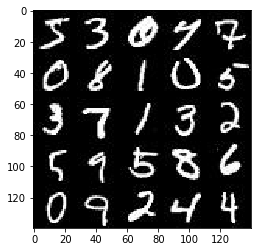

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

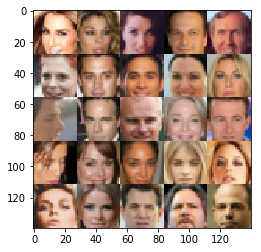

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_image')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return real_input_image, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch_norm = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch_norm, batch_norm)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):

        fullCon1 = tf.layers.dense(z, 4*4*512)

        fullCon1 = tf.reshape(fullCon1, (-1, 4, 4, 512))
        batch_norm1 = tf.layers.batch_normalization(fullCon1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        
        Conv1 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid')
        batch_norm2 = tf.layers.batch_normalization(Conv1, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        Conv2 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(Conv2, training=is_train)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)

        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images*2, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z}) # repat the ues of generator
                
                if steps % 10 == 0:
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')
        # show the final training result
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.2360... Generator Loss: 0.1055
Epoch 1/2... Discriminator Loss: 3.3421... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 2.3545... Generator Loss: 1.0576
Epoch 1/2... Discriminator Loss: 2.3785... Generator Loss: 0.3825
Epoch 1/2... Discriminator Loss: 2.0367... Generator Loss: 1.0324
Epoch 1/2... Discriminator Loss: 2.1184... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 1.9578... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 2.1016... Generator Loss: 0.5165
Epoch 1/2... Discriminator Loss: 1.9102... Generator Loss: 0.3853
Epoch 1/2... Discriminator Loss: 1.7555... Generator Loss: 0.3508


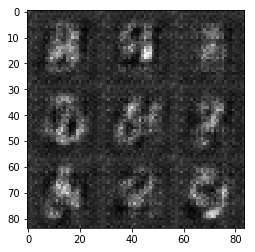

Epoch 1/2... Discriminator Loss: 1.7304... Generator Loss: 0.4052
Epoch 1/2... Discriminator Loss: 1.6561... Generator Loss: 0.4620
Epoch 1/2... Discriminator Loss: 1.7278... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 2.1627... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 1.9954... Generator Loss: 0.8446
Epoch 1/2... Discriminator Loss: 1.6340... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 1.7585... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.9179... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 1.6640... Generator Loss: 0.8814
Epoch 1/2... Discriminator Loss: 1.9297... Generator Loss: 1.1292


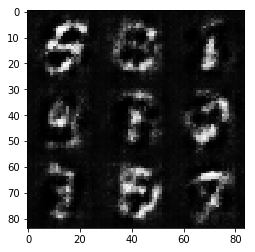

Epoch 1/2... Discriminator Loss: 1.9678... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 1.8017... Generator Loss: 0.9714
Epoch 1/2... Discriminator Loss: 1.7891... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 1.7521... Generator Loss: 0.3620
Epoch 1/2... Discriminator Loss: 1.5486... Generator Loss: 0.7184
Epoch 1/2... Discriminator Loss: 1.9065... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 1.8475... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.8250... Generator Loss: 0.8299
Epoch 1/2... Discriminator Loss: 2.0074... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 1.8789... Generator Loss: 0.7660


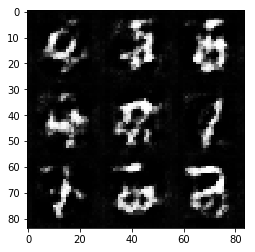

Epoch 1/2... Discriminator Loss: 1.8274... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 2.1235... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 1.7771... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.9329... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 1.9088... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 2.0240... Generator Loss: 0.2367
Epoch 1/2... Discriminator Loss: 1.7193... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 2.0774... Generator Loss: 1.1594
Epoch 1/2... Discriminator Loss: 2.0794... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 2.0108... Generator Loss: 0.9010


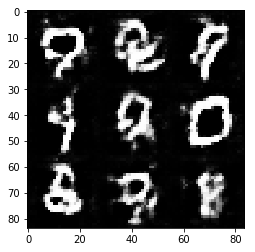

Epoch 1/2... Discriminator Loss: 1.9742... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 2.0515... Generator Loss: 0.8964
Epoch 1/2... Discriminator Loss: 1.7952... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.7390... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.7834... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.8529... Generator Loss: 0.3260
Epoch 1/2... Discriminator Loss: 1.7636... Generator Loss: 0.4160
Epoch 1/2... Discriminator Loss: 1.9434... Generator Loss: 0.5519
Epoch 1/2... Discriminator Loss: 1.8416... Generator Loss: 0.6323
Epoch 1/2... Discriminator Loss: 2.2770... Generator Loss: 1.3436


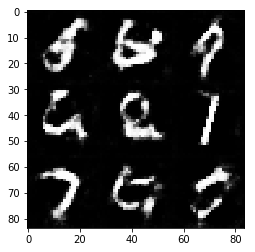

Epoch 1/2... Discriminator Loss: 1.8506... Generator Loss: 0.3260
Epoch 1/2... Discriminator Loss: 1.8542... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 1.6871... Generator Loss: 0.4205
Epoch 1/2... Discriminator Loss: 1.7885... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.9921... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 1.8224... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 1.9380... Generator Loss: 0.2950
Epoch 1/2... Discriminator Loss: 1.6180... Generator Loss: 0.5442
Epoch 1/2... Discriminator Loss: 1.9238... Generator Loss: 0.2545
Epoch 1/2... Discriminator Loss: 1.6938... Generator Loss: 0.5815


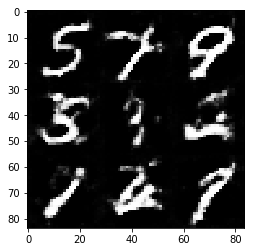

Epoch 1/2... Discriminator Loss: 2.1323... Generator Loss: 1.1791
Epoch 1/2... Discriminator Loss: 1.8168... Generator Loss: 0.7462
Epoch 1/2... Discriminator Loss: 1.7410... Generator Loss: 0.4079
Epoch 1/2... Discriminator Loss: 1.7849... Generator Loss: 0.3020
Epoch 1/2... Discriminator Loss: 1.6788... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 1.8085... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 1.8025... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 2.0398... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 1.6362... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 2.1179... Generator Loss: 1.0332


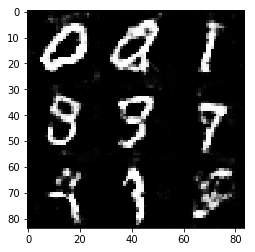

Epoch 1/2... Discriminator Loss: 1.7045... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.6901... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 2.2130... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.8608
Epoch 1/2... Discriminator Loss: 1.7244... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.6926... Generator Loss: 0.3319
Epoch 1/2... Discriminator Loss: 2.0206... Generator Loss: 0.1918
Epoch 1/2... Discriminator Loss: 1.6489... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 1.7065... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 1.6852... Generator Loss: 0.4127


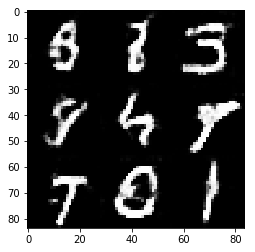

Epoch 1/2... Discriminator Loss: 1.6407... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.6293... Generator Loss: 0.7277
Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 0.3532
Epoch 1/2... Discriminator Loss: 1.9346... Generator Loss: 0.2066
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.6289
Epoch 1/2... Discriminator Loss: 1.5807... Generator Loss: 0.4428
Epoch 1/2... Discriminator Loss: 1.9692... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.7008... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.9948... Generator Loss: 0.2079
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.6959


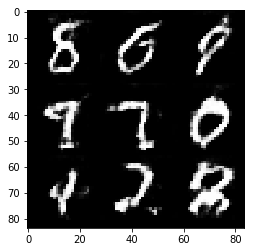

Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 2.0523... Generator Loss: 1.1922
Epoch 1/2... Discriminator Loss: 1.8204... Generator Loss: 0.4260
Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 0.7859
Epoch 2/2... Discriminator Loss: 1.6317... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: 2.4248... Generator Loss: 1.2944
Epoch 2/2... Discriminator Loss: 1.8427... Generator Loss: 0.5954
Epoch 2/2... Discriminator Loss: 1.7655... Generator Loss: 0.3279
Epoch 2/2... Discriminator Loss: 1.9367... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 1.7857... Generator Loss: 0.8100


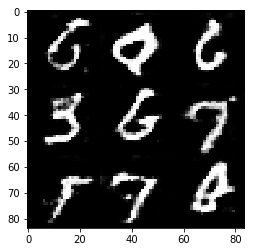

Epoch 2/2... Discriminator Loss: 1.5261... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.6853... Generator Loss: 0.4116
Epoch 2/2... Discriminator Loss: 1.6101... Generator Loss: 0.3859
Epoch 2/2... Discriminator Loss: 1.9832... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.5898... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 1.8117... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 1.8341... Generator Loss: 0.3600
Epoch 2/2... Discriminator Loss: 1.7138... Generator Loss: 0.4536
Epoch 2/2... Discriminator Loss: 1.8695... Generator Loss: 0.2691
Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 1.0482


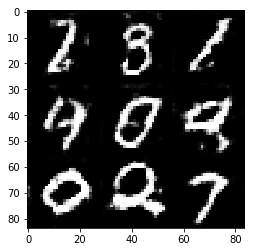

Epoch 2/2... Discriminator Loss: 1.4410... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 1.5875... Generator Loss: 0.5283
Epoch 2/2... Discriminator Loss: 1.5763... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 1.5490... Generator Loss: 0.6450
Epoch 2/2... Discriminator Loss: 1.8868... Generator Loss: 0.2501
Epoch 2/2... Discriminator Loss: 1.6006... Generator Loss: 0.5269
Epoch 2/2... Discriminator Loss: 1.6489... Generator Loss: 0.4387
Epoch 2/2... Discriminator Loss: 1.6482... Generator Loss: 0.4992
Epoch 2/2... Discriminator Loss: 1.7758... Generator Loss: 0.3329
Epoch 2/2... Discriminator Loss: 1.5773... Generator Loss: 0.5144


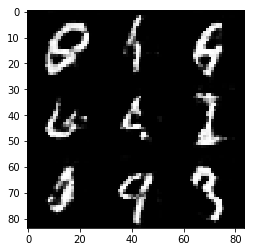

Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 0.5233
Epoch 2/2... Discriminator Loss: 1.6458... Generator Loss: 0.9553
Epoch 2/2... Discriminator Loss: 1.9605... Generator Loss: 0.2685
Epoch 2/2... Discriminator Loss: 1.6698... Generator Loss: 0.3184
Epoch 2/2... Discriminator Loss: 1.6470... Generator Loss: 0.5796
Epoch 2/2... Discriminator Loss: 1.6561... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 1.8302... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 1.8583... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 1.8920... Generator Loss: 1.9913
Epoch 2/2... Discriminator Loss: 3.4224... Generator Loss: 2.0468


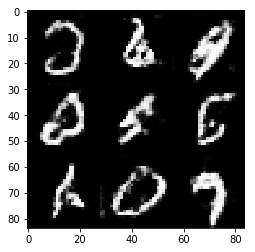

Epoch 2/2... Discriminator Loss: 1.7248... Generator Loss: 0.4000
Epoch 2/2... Discriminator Loss: 3.0211... Generator Loss: 1.7313
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 2.2403... Generator Loss: 0.1516
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.5581... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 1.6212... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 1.6053... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 2.2249... Generator Loss: 0.4878


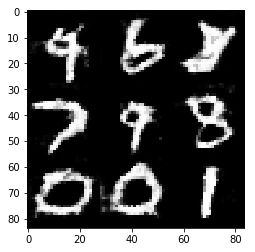

Epoch 2/2... Discriminator Loss: 2.5772... Generator Loss: 0.1132
Epoch 2/2... Discriminator Loss: 1.6731... Generator Loss: 0.6096
Epoch 2/2... Discriminator Loss: 1.9375... Generator Loss: 0.3727
Epoch 2/2... Discriminator Loss: 1.5810... Generator Loss: 0.6175
Epoch 2/2... Discriminator Loss: 1.6303... Generator Loss: 0.3131
Epoch 2/2... Discriminator Loss: 1.5683... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 1.6946... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 1.4926... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.4977... Generator Loss: 0.6280
Epoch 2/2... Discriminator Loss: 3.0384... Generator Loss: 0.0759


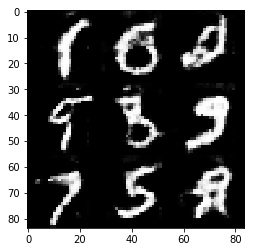

Epoch 2/2... Discriminator Loss: 1.4919... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.6355... Generator Loss: 0.4657
Epoch 2/2... Discriminator Loss: 1.5980... Generator Loss: 1.3489
Epoch 2/2... Discriminator Loss: 1.5597... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.4735... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.8505... Generator Loss: 0.2219
Epoch 2/2... Discriminator Loss: 1.7782... Generator Loss: 0.5030
Epoch 2/2... Discriminator Loss: 1.9477... Generator Loss: 0.3062
Epoch 2/2... Discriminator Loss: 2.0493... Generator Loss: 0.1888
Epoch 2/2... Discriminator Loss: 1.9811... Generator Loss: 0.6587


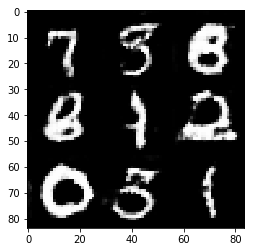

Epoch 2/2... Discriminator Loss: 1.8793... Generator Loss: 0.3630
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 1.1808
Epoch 2/2... Discriminator Loss: 2.0344... Generator Loss: 0.3658
Epoch 2/2... Discriminator Loss: 2.1462... Generator Loss: 0.2385
Epoch 2/2... Discriminator Loss: 1.9107... Generator Loss: 0.2521
Epoch 2/2... Discriminator Loss: 1.6541... Generator Loss: 2.3815
Epoch 2/2... Discriminator Loss: 1.6814... Generator Loss: 0.4815
Epoch 2/2... Discriminator Loss: 1.7637... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 1.8878... Generator Loss: 0.3639
Epoch 2/2... Discriminator Loss: 2.4504... Generator Loss: 0.3227


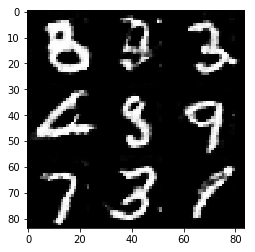

Epoch 2/2... Discriminator Loss: 1.8887... Generator Loss: 0.3551
Epoch 2/2... Discriminator Loss: 2.1852... Generator Loss: 0.4673
Epoch 2/2... Discriminator Loss: 1.8735... Generator Loss: 0.3650
Epoch 2/2... Discriminator Loss: 1.7130... Generator Loss: 0.4769
Epoch 2/2... Discriminator Loss: 2.3020... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 2.1452... Generator Loss: 0.5017
Epoch 2/2... Discriminator Loss: 1.9354... Generator Loss: 0.3976
Epoch 2/2... Discriminator Loss: 2.5013... Generator Loss: 0.1403
Epoch 2/2... Discriminator Loss: 1.6251... Generator Loss: 0.3391
Epoch 2/2... Discriminator Loss: 2.0719... Generator Loss: 0.8877


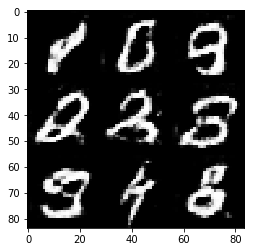

Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 2.0565... Generator Loss: 0.2591
Epoch 2/2... Discriminator Loss: 2.0273... Generator Loss: 0.4548
Epoch 2/2... Discriminator Loss: 1.9525... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 2.0575... Generator Loss: 0.3480
Epoch 2/2... Discriminator Loss: 1.8862... Generator Loss: 0.4612


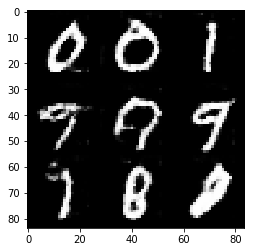

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.3506... Generator Loss: 0.0655
Epoch 1/1... Discriminator Loss: 2.9290... Generator Loss: 0.2545
Epoch 1/1... Discriminator Loss: 3.4123... Generator Loss: 0.1594
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.9493... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 2.5638
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 2.2082... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.7677


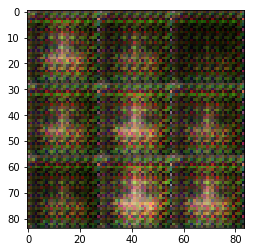

Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 2.0033... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.8550... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 2.1316... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.6370


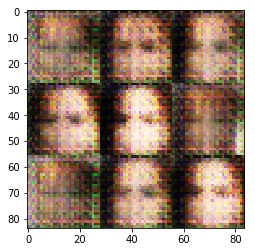

Epoch 1/1... Discriminator Loss: 1.8690... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.6324... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.6575


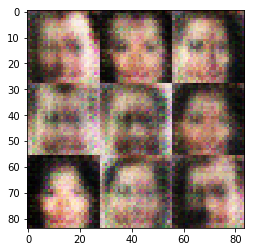

Epoch 1/1... Discriminator Loss: 1.7022... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6264


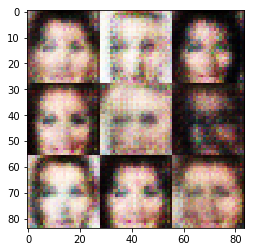

Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.6187


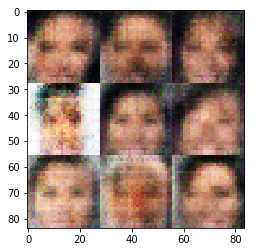

Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.6256


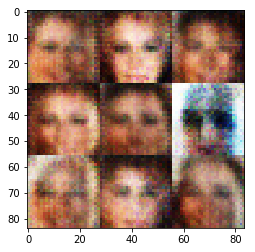

Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.6531... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6701


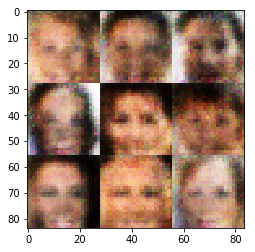

Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.6381


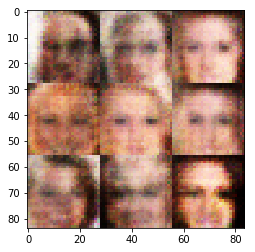

Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6343


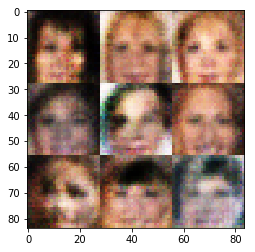

Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6340


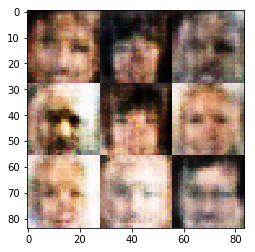

Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6353


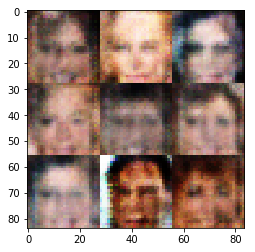

Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7089


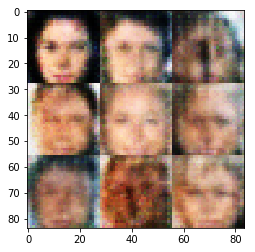

Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6621


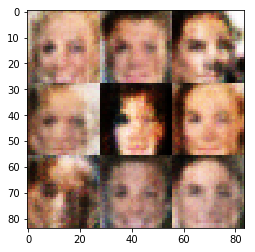

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6430


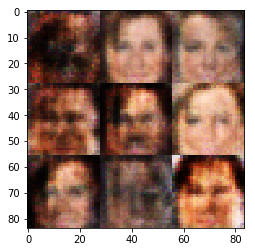

Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6476


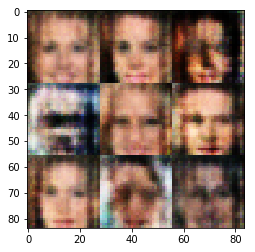

Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7063


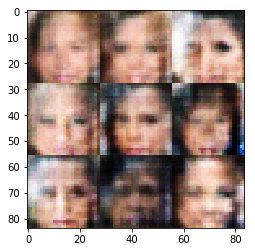

In [23]:
batch_size = 128
z_dim = 98
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.